# Roberta with preprocessing dataset and balanced 



In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# 2. Loading Patronize Dataset


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!cp gdrive/MyDrive/Imbalance_prepare/imbalance_test_DPM_preprocessing.pkl .
!cp gdrive/MyDrive/Imbalance_prepare/imbalance_train_DPM_preprocessing.pkl .
import pandas as pd

In [5]:
trainDFRead = pd.read_pickle("imbalance_train_DPM_preprocessing.pkl")
trainDFRead.head()

,par_id,sentence,label
99,105,satisfaction lies in permitting others to live...,0
7866,8693,terminal remission which means no seizures for...,0
5321,5875,the collapse of oil prices has had a far more ...,0
813,9488,foundation became an oasis for grant s pen re...,1
4756,5247,assure action against illegal immigrants amp e...,0


In [6]:
import random
import os
from urllib import request

In [7]:
trainDFRead.shape

(9788, 3)

In [8]:
# Get the lists of sentences and their labels.
sentences = trainDFRead.sentence.values
labels = trainDFRead.label.values

In [9]:
% pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


## 1.2. Installing the Hugging Face Library


In [10]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 6.8 MB 60.5 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
     |████████████████████████████████| 895 kB 78.6 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## 3.1. RobertaTokenizer

In [11]:
from transformers import RobertaTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Let's apply the tokenizer to one sentence just to see the output.


In [12]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  satisfaction lies in permitting others to live not living others lives never try to clutch someone else share always reproduce your own complexion and gore people swallowed helpless and hopeless but still sobbed due to plea of their conscience i have grasped and wiped those tears who were the reason of their own cause 
Tokenized:  ['s', 'atisf', 'action', 'Ġlies', 'Ġin', 'Ġpermitting', 'Ġothers', 'Ġto', 'Ġlive', 'Ġnot', 'Ġliving', 'Ġothers', 'Ġlives', 'Ġnever', 'Ġtry', 'Ġto', 'Ġclutch', 'Ġsomeone', 'Ġelse', 'Ġshare', 'Ġalways', 'Ġreproduce', 'Ġyour', 'Ġown', 'Ġcomplexion', 'Ġand', 'Ġgore', 'Ġpeople', 'Ġswallowed', 'Ġhelpless', 'Ġand', 'Ġhopeless', 'Ġbut', 'Ġstill', 'Ġsob', 'bed', 'Ġdue', 'Ġto', 'Ġplea', 'Ġof', 'Ġtheir', 'Ġconscience', 'Ġi', 'Ġhave', 'Ġgrasped', 'Ġand', 'Ġwiped', 'Ġthose', 'Ġtears', 'Ġwho', 'Ġwere', 'Ġthe', 'Ġreason', 'Ġof', 'Ġtheir', 'Ġown', 'Ġcause', 'Ġ']
Token IDs:  [29, 33315, 10845, 5738, 11, 19289, 643, 7, 697, 45, 1207, 643, 1074, 393, 860, 7, 18210, 

## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [13]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  402


Just in case there are some longer test sentences, I'll set the maximum length to 512.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  satisfaction lies in permitting others to live not living others lives never try to clutch someone else share always reproduce your own complexion and gore people swallowed helpless and hopeless but still sobbed due to plea of their conscience i have grasped and wiped those tears who were the reason of their own cause 
Token IDs: tensor([    0,    29, 33315, 10845,  5738,    11, 19289,   643,     7,   697,
           45,  1207,   643,  1074,   393,   860,     7, 18210,   951,  1493,
          458,   460, 33942,   110,   308, 29914,     8, 43739,    82, 32305,
        22445,     8, 24418,    53,   202, 18769,  5134,   528,     7,  6221,
            9,    49, 19235,   939,    33, 43367,     8, 16492,   167,  6941,
           54,    58,     5,  1219,     9,    49,   308,  1303,  1437,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     

## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,809 training samples
  979 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [16]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

148

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

## 4.1. RobertaForSequenceClassification

In [18]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

# Load RobertaForSequenceClassification , the pretrained BERT model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [19]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-7, # args.learning_rate - default is 5e-5, our notebook had 2e-5, Ilan: try 5e-6
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [21]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [24]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    551.    Elapsed: 0:00:34.
  Batch    80  of    551.    Elapsed: 0:01:09.
  Batch   120  of    551.    Elapsed: 0:01:43.
  Batch   160  of    551.    Elapsed: 0:02:17.
  Batch   200  of    551.    Elapsed: 0:02:51.
  Batch   240  of    551.    Elapsed: 0:03:26.
  Batch   280  of    551.    Elapsed: 0:04:00.
  Batch   320  of    551.    Elapsed: 0:04:34.
  Batch   360  of    551.    Elapsed: 0:05:08.
  Batch   400  of    551.    Elapsed: 0:05:43.
  Batch   440  of    551.    Elapsed: 0:06:17.
  Batch   480  of    551.    Elapsed: 0:06:51.
  Batch   520  of    551.    Elapsed: 0:07:25.

  Average training loss: 0.59
  Training epcoh took: 0:07:52

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.52
  Validation took: 0:00:18

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    551.    Elapsed: 0:00:34.
  Batch    80  of    551.    Elapsed: 0:01:08.
  Batch   120  of    551.    Elapsed: 0:01:43.
  Batch  

Let's view the summary of the training process.

In [25]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.59,0.52,0.74,0:07:52,0:00:18
2,0.41,0.38,0.74,0:07:52,0:00:18
3,0.34,0.35,0.74,0:07:52,0:00:18
4,0.31,0.33,0.90,0:07:52,0:00:18
5,0.30,0.32,0.91,0:07:52,0:00:18


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

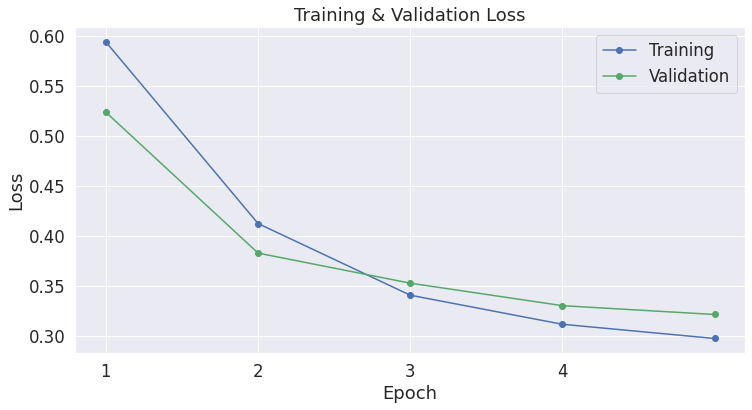

In [26]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1,5))

plt.show()

# 5. Performance On Test Set

In [27]:
testDFRead = pd.read_pickle("imbalance_test_DPM_preprocessing.pkl")
testDFRead.head()

,par_id,sentence,label
4537,5003,that young men in this city are hopelessly bro...,0
408,4684,unemployment physical and mental illness phys...,1
3838,4248,this is a day that should not a be day of desp...,0
6522,7221,officials have said that those rohingya now in...,0
467,6260,has managed to accept immigrants yet it keeps...,1


In [28]:
sentences = trainDFRead.sentence.values
labels = trainDFRead.label.values

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [29]:
test_size = len(sentences)
test_size

9788

In [30]:
import pandas as pd

# Load the dataset into a pandas dataframe.
# df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print(f'Number of test sentences: {test_size}\n')

# Create sentence and label lists
#sentences = df.sentence.values

#labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  Ilan: set batch_size = 1 so pred_labels_i or append pred_labels_i in one list
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 9788



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [31]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 9,788 test sentences...
    DONE.


In [32]:
#

Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [33]:
print('Positive samples: %d of %d (%.2f%%)' % (labels.sum(), len(labels), (labels.sum() / len(labels) * 100.0)))

Positive samples: 2231 of 9788 (22.79%)


In [34]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
pred_labels_list = []
actual_labels_list = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  print(f'Prediction: {pred_labels_i} - Actual: {true_labels[i]}')
  pred_labels_list.extend(pred_labels_i)
  actual_labels_list.extend(true_labels[i])
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...
Prediction: [0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0] - Actual: [0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0]
Prediction: [1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0] - Actual: [1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
Prediction: [0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0] - Actual: [0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0]
Prediction: [1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0] - Actual: [1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
Prediction: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1] - Actual: [0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1]
Prediction: [1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1] - Actual: [1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0]
Prediction: [0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0] - Actual: [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0]
Prediction: [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1] - Actual: [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0]
Prediction: [0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0] - Actual: [0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0]
Prediction: [0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0] - Actual: [0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0]
Prediction: [1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0] - A

In [35]:
# helper function to save predictions to an output file
def labels2file(my_list, outf_path):
  with open(outf_path,'w') as outf:
    for item in my_list:
      outf.write("%s\n" % item)

In [36]:
# first, we need to create the res/ and ref/ folders, which the evaluator expects
!mkdir ref res

In [37]:
# random predictions for task 1
labels2file(pred_labels_list, os.path.join('res/', 'task1.txt'))

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


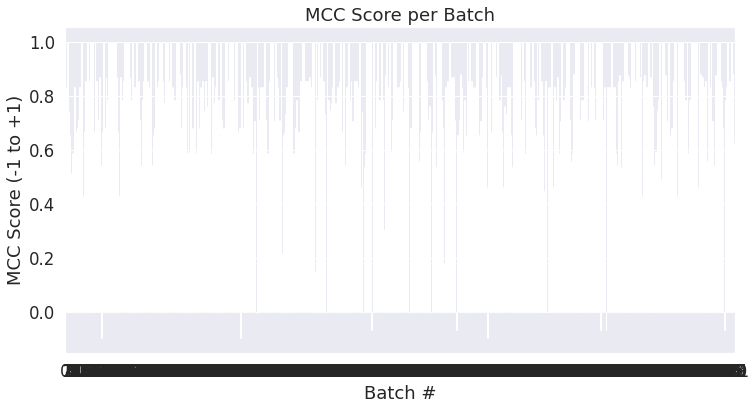

In [38]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [39]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.784


In [40]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(actual_labels_list,pred_labels_list)))

Precision score: 0.8422018348623853


In [41]:
from sklearn.metrics import recall_score

print("Recall score: {}".format(recall_score(actual_labels_list,pred_labels_list)))

Recall score: 0.8229493500672345


In [42]:
from sklearn.metrics import f1_score

print("F1 Score: {}".format(f1_score(actual_labels_list,pred_labels_list)))

F1 Score: 0.8324642938109271


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = ['Not Patronizing','Is Patronizing']
print(classification_report(actual_labels_list, pred_labels_list, target_names=class_names))
print(confusion_matrix(actual_labels_list, pred_labels_list))

                 precision    recall  f1-score   support

Not Patronizing       0.95      0.95      0.95      7557
 Is Patronizing       0.84      0.82      0.83      2231

       accuracy                           0.92      9788
      macro avg       0.90      0.89      0.89      9788
   weighted avg       0.92      0.92      0.92      9788

[[7213  344]
 [ 395 1836]]


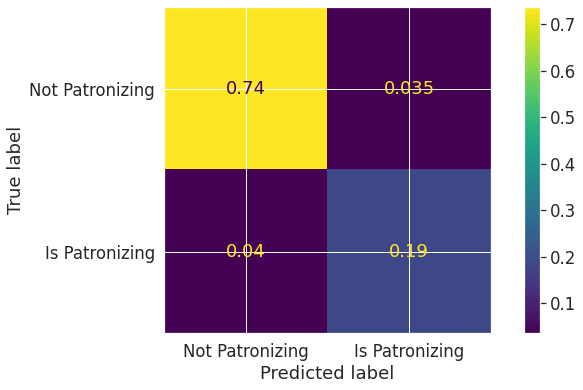

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actual_labels_list, pred_labels_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Not Patronizing','Is Patronizing'])
cmd.plot()

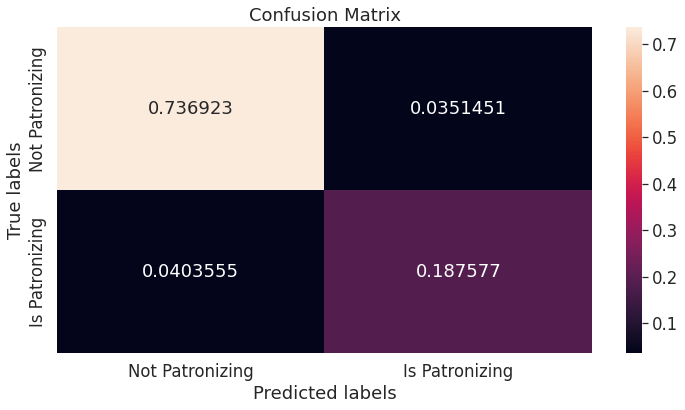

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Patronizing','Is Patronizing']); ax.yaxis.set_ticklabels(['Not Patronizing','Is Patronizing']);

# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [46]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = F"/content/gdrive/MyDrive/roberta_5_preprocessing_imbalance"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/gdrive/MyDrive/roberta_5_preprocessing_imbalance


('/content/gdrive/MyDrive/roberta_5_preprocessing_imbalance/tokenizer_config.json',
 '/content/gdrive/MyDrive/roberta_5_preprocessing_imbalance/special_tokens_map.json',
 '/content/gdrive/MyDrive/roberta_5_preprocessing_imbalance/vocab.json',
 '/content/gdrive/MyDrive/roberta_5_preprocessing_imbalance/merges.txt',
 '/content/gdrive/MyDrive/roberta_5_preprocessing_imbalance/added_tokens.json')

In [47]:
model_save_name = 'roberta_5_preprocessing_imbalance.pt'
path_google_drive = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model, path_google_drive)

Let's check out the file sizes, out of curiosity.

In [48]:
!ls -l --block-size=K {output_dir}

total 488314K
-rw------- 1 root root      1K Jan 31 14:44 config.json
-rw------- 1 root root    446K Jan 31 14:44 merges.txt
-rw------- 1 root root 486987K Jan 31 14:44 pytorch_model.bin
-rw------- 1 root root      1K Jan 31 14:44 special_tokens_map.json
-rw------- 1 root root      2K Jan 31 14:44 tokenizer_config.json
-rw------- 1 root root    878K Jan 31 14:44 vocab.json


The largest file is the model weights, at around 418 megabytes.

In [49]:
!ls -l --block-size=M {output_dir}/pytorch_model.bin

-rw------- 1 root root 476M Jan 31 14:44 /content/gdrive/MyDrive/roberta_5_preprocessing_imbalance/pytorch_model.bin


In [50]:
from transformers import XLNetConfig, XLMForSequenceClassification, XLMTokenizer
from transformers import XLMConfig, XLNetForSequenceClassification, XLNetTokenizer
from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
from transformers import DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer


The following functions will load the model back from disk.

In [51]:

MODEL_CLASSES = {
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer),
    'albert': (AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer)
}	

# Config class and load a trained model and vocabulary 
config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta']
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN